In [10]:
# 표준 라이브러리
from pathlib import Path
import sys
import platform

# 서드 파티 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

## 통계 모듈
from scipy import stats
from scipy.stats import chi2_contingency

# 로컬 모듈
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'src'))
from src.plot import plot_stacked_bar, plot_heatmap, plot_features
from src.utils import cramers_v, interpret_cramers_v, check_expected_frequencies, standardized_residuals
from src.utils import check_normality, check_homogeneity, calculate_epsilon_squared
from src.utils import generate_colormap
from src.config import DATA_DIR, FONT_DIR

colors = ['#0A4EE4', '#AED6E0', '#9BC4D5', '#758A98', '#3E4E5F']

In [11]:
# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
prop = fm.FontProperties(fname=font_path)

In [12]:
pandas_kwargs = {
    'parse_dates': ['purchase_time', 'approved_time', 'carrier_delivered_time', 'delivered_time', 'estimated_delivery_time'],
    'date_format': '%Y-%m-%d %H:%M:%S',
    'memory_map': True
}

processed_data = pd.read_csv(DATA_DIR / 'processed' / 'processed_data.csv', **pandas_kwargs)
processed_data

,order_id,order_qty,total_price,product_id,product_qty,category,review_score,price,freight_value,purchase_time,...,city_cust,state_cust,customer_id,customer_unique_id,seller_id,zip_code_sell,city_sell,state_sell,latitude_sell,longitude_sell
0,00e7ee1b050b8499577073aeb2a297a1,1,146.87,a9516a079e37a9c9c36b9b78b10169e8,1,가구·인테리어,4.0,124.99,21.88,2017-05-16 15:05:35,...,franca,SP,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,7c67e1448b00f6e969d365cea6b010ab,8577,itaquaquecetuba,SP,-23.479473,-46.360819
1,29150127e6685892b6eab3eec79f59c7,1,335.48,4aa6014eceb682077f9dc4bffebc05b0,1,생활용품,5.0,289.00,46.48,2018-01-12 20:48:24,...,sao bernardo do campo,SP,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,b8bc237ba3788b23da09c0f1f3a3288c,88303,itajai,SC,-26.920912,-48.684937
2,b2059ed67ce144a36e2aa97d2c9e9ad2,1,157.73,bd07b66896d6f1494f5b86251848ced7,1,가구·인테리어,5.0,139.94,17.79,2018-05-19 16:07:45,...,sao paulo,SP,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,7c67e1448b00f6e969d365cea6b010ab,8577,itaquaquecetuba,SP,-23.479473,-46.360819
3,951670f92359f4fe4a63112aa7306eba,1,173.30,a5647c44af977b148e0a3a4751a09e2e,1,가구·인테리어,5.0,149.94,23.36,2018-03-13 16:06:38,...,mogi das cruzes,SP,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,7c67e1448b00f6e969d365cea6b010ab,8577,itaquaquecetuba,SP,-23.479473,-46.360819
4,6b7d50bd145f6fc7f33cebabd7e49d0f,1,252.25,9391a573abe00141c56e38d84d7d5b3b,1,가구·인테리어,5.0,230.00,22.25,2018-07-29 09:51:30,...,campinas,SP,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,4a3ca9315b744ce9f8e9374361493884,14940,ibitinga,SP,-21.774868,-48.847152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100696,6760e20addcf0121e9d58f2f1ff14298,1,88.78,ccb4503d9d43d245d3b295d0544f988b,1,도서·미디어,4.0,74.90,13.88,2018-04-07 15:48:17,...,sao paulo,SP,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,527801b552d0077ffd170872eb49683b,17400,garca,SP,-22.210402,-49.662731
100697,9ec0c8947d973db4f4e8dcf1fbfa8f1b,1,129.06,9ede6b0570a75a4b9de4f383329f99ee,1,스포츠·레저,5.0,114.90,14.16,2018-04-04 08:20:22,...,taboao da serra,SP,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,3fd1e727ba94cfe122d165e176ce7967,14802,araraquara,SP,-21.775406,-48.168105
100698,fed4434add09a6f332ea398efd656a5c,1,56.04,7a5d2e1e131a860ae7d18f6fffa9d689,1,건강·뷰티,1.0,37.00,19.04,2018-04-08 20:11:50,...,fortaleza,CE,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,d9e7e7778b32987280a6f2cb9a39c57d,3304,sao paulo,SP,-23.545397,-46.581221
100699,e31ec91cea1ecf97797787471f98a8c2,1,711.07,f819f0c84a64f02d3a5606ca95edd272,1,패션·의류,5.0,689.00,22.07,2017-11-03 21:08:33,...,canoas,RS,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,4869f7a5dfa277a7dca6462dcf3b52b2,14840,guariba,SP,-21.369332,-48.225907


In [13]:
# 북동부
target_state_cust = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']

processed_data = processed_data.loc[processed_data['state_cust'].isin(target_state_cust)].copy()

## 배송지연 x 재구매

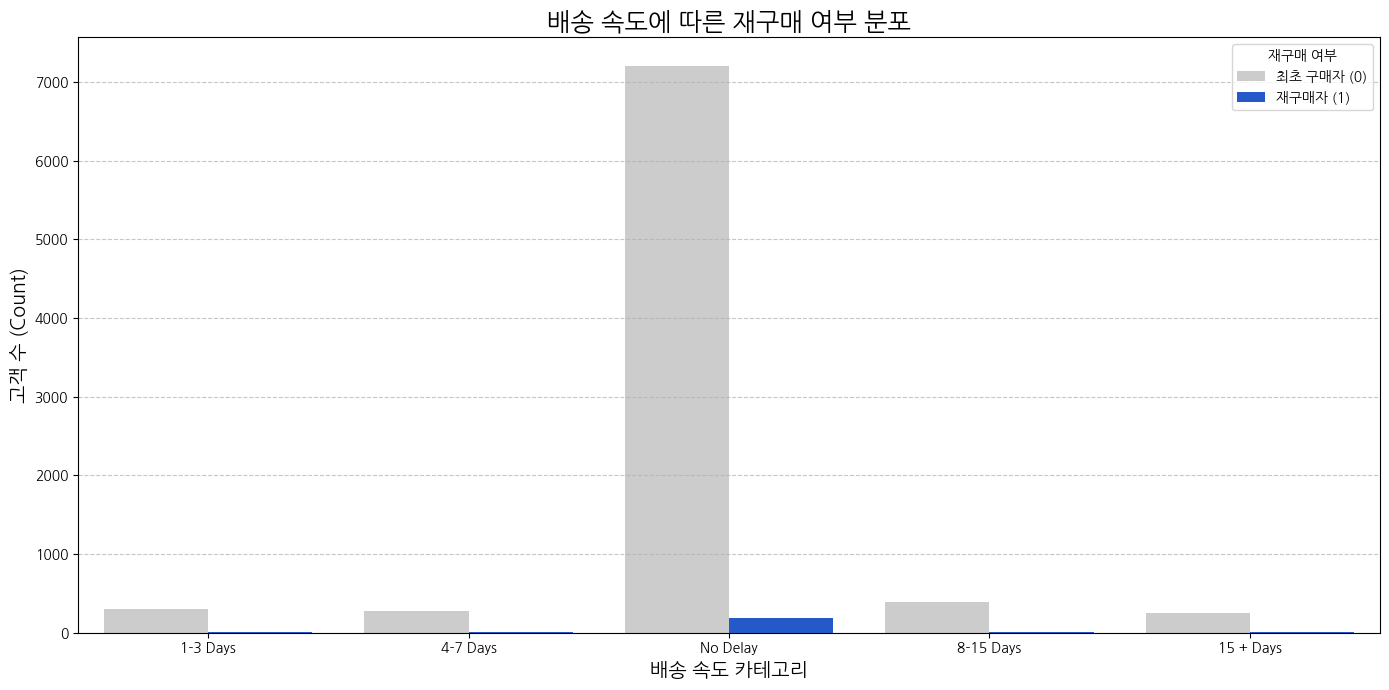

/tmp/ipykernel_614085/3946920663.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_614085/3946920663.py:86: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  ax = sns.barplot(


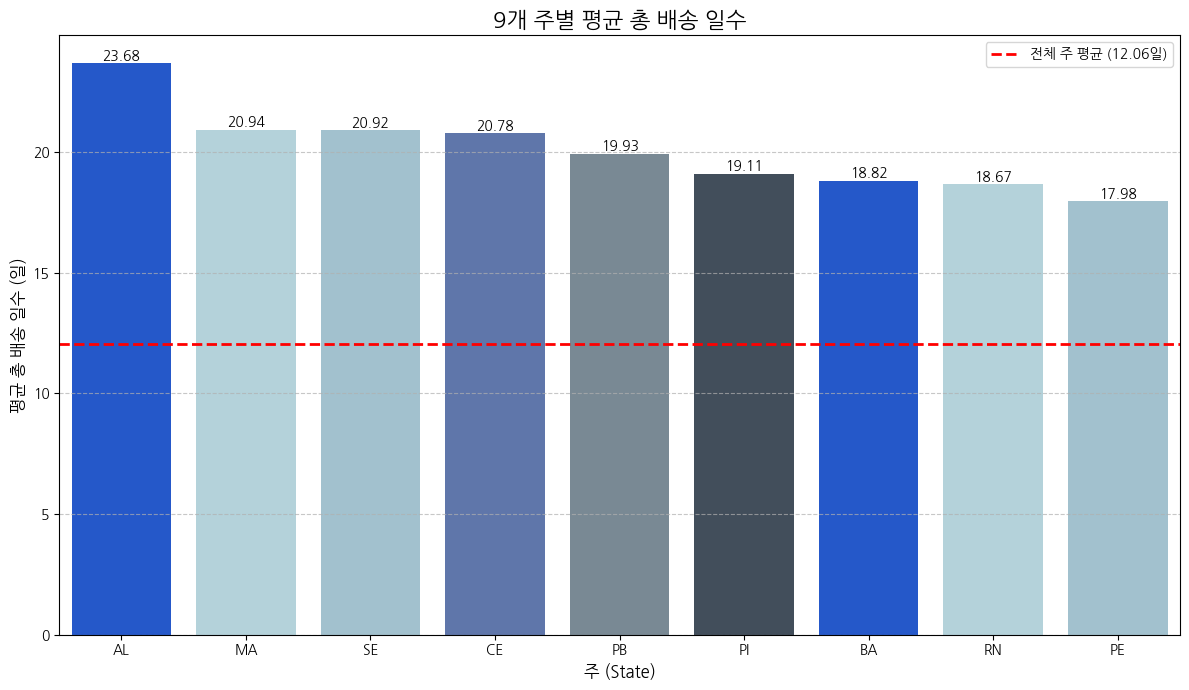

In [14]:
customer_df = pd.read_csv(DATA_DIR / 'processed' / 'customer_data.csv', **pandas_kwargs)
customer_df2 = customer_df.copy()

## 예상 - 실제 배달 컬럼 생성
customer_df2['estimated_delivery_time'] = pd.to_datetime(customer_df2['estimated_delivery_time'], errors='coerce')
customer_df2['delivered_time'] = pd.to_datetime(customer_df2['delivered_time'], errors='coerce')
customer_df2['early_delivery_days'] = (
    customer_df2['estimated_delivery_time'] - customer_df2['delivered_time']
).dt.days
## 타겟 지정
target_states = ['CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'MA', 'PI', 'BA']
## 타겟 추출
target_early_delivery = customer_df2[customer_df2['state'].isin(target_states)].copy()
## 주 그룹바이 평균
customer_summary = target_early_delivery.groupby('customer_unique_id').agg(
    Repurchase_YN=('order_id', lambda x: 1 if x.nunique() > 1 else 0),
    avg_total_delivery_days=('early_delivery_days', 'mean')
).reset_index()
## 배송속도 카테고리 생성
delivery_cate = [
    customer_summary['avg_total_delivery_days'] >=0,
    (customer_summary['avg_total_delivery_days'] < 0) & (customer_summary['avg_total_delivery_days'] >= -3),
    (customer_summary['avg_total_delivery_days'] < -3) & (customer_summary['avg_total_delivery_days'] >= -7),
    (customer_summary['avg_total_delivery_days'] < -7) & (customer_summary['avg_total_delivery_days'] >= -15),
    customer_summary['avg_total_delivery_days'] < -15
]
choices = [
    'No Delay',
    '1-3 Days',
    '4-7 Days',
    '8-15 Days',
    '15 + Days'
]
customer_summary['avg_total_delivery_days'] = np.select(delivery_cate, choices, default='분류 불가')
## 그래프 생성
category_order = ['1-3 Days', '4-7 Days', 'No Delay', '8-15 Days', '15 + Days']

plt.figure(figsize=(14, 7))
ax = sns.countplot(
    x='avg_total_delivery_days',
    hue='Repurchase_YN',
    data=customer_summary,
    order=category_order,
    palette={0: '#CCCCCC', 1: '#0A4EE4'}
)
plt.title('배송 속도에 따른 재구매 여부 분포', fontsize=18)
plt.xlabel('배송 속도 카테고리', fontsize=14)
plt.ylabel('고객 수 (Count)', fontsize=14)
legend_labels = ['최초 구매자 (0)', '재구매자 (1)']
ax.legend(title='재구매 여부', labels=legend_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 혹시를 대비해서
customer_df2 = customer_df.copy()
## 배송기간 컬럼 생성
try:
    customer_df2['delivered_time'] = pd.to_datetime(customer_df2['delivered_time'], errors='coerce')
    customer_df2['purchase_time'] = pd.to_datetime(customer_df2['purchase_time'], errors='coerce')
    customer_df2['Total_Delivery_Time'] = customer_df2['delivered_time'] - customer_df2['purchase_time']
    customer_df2['Total_Delivery_Days'] = customer_df2['Total_Delivery_Time'].dt.days
except NameError:
    print(f':x: 오류: customer_df2 데이터프레임이 정의되지 않았습니다. 변수명을 확인해 주세요.')
except KeyError as e:
    print(f':x: 오류: 필요한 컬럼이 DataFrame에 없습니다. 컬럼명을 확인하세요: {e}')
## 타겟 지정
target_states = ['CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'MA', 'PI', 'BA']
## 타겟 추출
df_target_delivery = customer_df2[customer_df2['state'].isin(target_states)].copy()
## 그룹바이해서 평균 구하기
try:
    state_delivery_mean = df_target_delivery.groupby('state')['Total_Delivery_Days'].mean().reset_index(name='Avg_Delivery_Days')
    state_delivery_mean['Avg_Delivery_Days'] = state_delivery_mean['Avg_Delivery_Days'].round(2)
    state_delivery_mean.sort_values(by='Avg_Delivery_Days', ascending=False, inplace=True)
except NameError:
    print(':x: 오류: df_target_delivery 데이터프레임이 정의되지 않았습니다. 변수명을 확인해 주세요.')
except KeyError as e:
    print(f':x: 오류: 필요한 컬럼 (state 또는 Total_Delivery_Days)이 DataFrame에 없습니다. 컬럼명을 확인하세요: {e}')
## 전체 주 평균 배송기간
all_state_mean_delivery = customer_df2['Total_Delivery_Days'].mean()
## 그래프 생성
custom_colors = ['#0A4EE4', '#AED6E0', '#9BC4D5', '#5271B7', '#758A98', '#3E4E5F']

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='state',
    y='Avg_Delivery_Days',
    data=state_delivery_mean,
    palette=custom_colors * (len(state_delivery_mean) // len(custom_colors) + 1)
)
plt.axhline(
    y=all_state_mean_delivery,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'전체 주 평균 ({all_state_mean_delivery:.2f}일)' # 범례에 표시될 라벨
)
plt.legend()
plt.title('9개 주별 평균 총 배송 일수', fontsize=16)
plt.xlabel('주 (State)', fontsize=12)
plt.ylabel('평균 총 배송 일수 (일)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.show()

## 파생변수 생성

In [ ]:
# 시간 파생변수

processed_data['배송일'] = (
    processed_data['delivered_time'] - 
    processed_data['purchase_time']
).dt.days

processed_data['승인시간'] = (
    processed_data['approved_time'] - 
    processed_data['purchase_time']
).dt.total_seconds().div(3600).round()

processed_data['인수시간'] = (
    processed_data['carrier_delivered_time'] - 
    processed_data['approved_time']
).dt.total_seconds().div(3600).round()

processed_data['운송시간'] = (
    processed_data['delivered_time'] - 
    processed_data['carrier_delivered_time']
).dt.total_seconds().div(3600).round()

processed_data['지연일'] = (
    processed_data['delivered_time'] - 
    processed_data['estimated_delivery_time']
).dt.days


processed_data['배송지연'] = (processed_data['지연일'] > 0).astype(int)

In [ ]:
order_data = processed_data.drop_duplicates('order_id').copy()

In [ ]:
# 고객별 주문 횟수 계산
customer_order_counts = order_data.groupby('customer_unique_id').size().reset_index(name='주문횟수')

# 각 주문이 몇 번째 주문인지 표시
order_data = order_data.sort_values(['customer_unique_id', 'purchase_time'])
order_data['구매순서'] = order_data.groupby('customer_unique_id').cumcount() + 1

# 첫 구매 여부
order_data['첫구매'] = (order_data['구매순서'] == 1).astype(int)

In [ ]:
# 3-6. 재구매 여부 (첫 구매 기준)
first_orders = order_data[order_data['첫구매'] == 1].copy()
first_orders = first_orders.merge(customer_order_counts, on='customer_unique_id', how='left')
first_orders['재구매'] = (first_orders['주문횟수'] >= 2).astype(int)

In [ ]:
print(f'✓ 전체 고객 수: {len(customer_order_counts):,}명')
print(f'✓ 첫 구매 데이터: {len(first_orders):,}건')
print(f'✓ 재구매 고객 수: {first_orders['재구매'].sum():,}명')
print(f'✓ 전체 재구매율: {first_orders['재구매'].mean()*100:.2f}%')

## 가설 검정 

In [ ]:
var1 = '배송일'
var2 = '재구매'

In [ ]:
plot_features(first_orders, [var1], colors[:1])

In [ ]:
left = -100
right = 200
left = -1
right = 100
outlier_cond = first_orders[var1] > left
outlier_cond &= first_orders[var1] < right
removed_data = first_orders[outlier_cond]

# removed_data, _, _ = detect_and_remove_outliers(first_orders, var1)

plot_features(removed_data, [var1], colors[:1])

In [ ]:
data = removed_data.copy()

In [ ]:
# =============================================================================
# 4. 기술통계 분석
# =============================================================================
print('\n' + '=' * 80)
print('📊 [4단계] 기술통계 분석')
print('=' * 80)

print(f'\n[{var1} 기술통계]')
var_stats = data[var1].describe()
print(var_stats)

# print(f'\n✓ 조기 도착 비율: {(data[var1] < 0).mean()*100:.2f}%')
# print(f'✓ 정시 도착 비율: {(data[var1] == 0).mean()*100:.2f}%')
# print(f'✓ 지연 도착 비율: {(data[var1] > 0).mean()*100:.2f}%')


In [ ]:
# =============================================================================
# 5. 클래스 불균형 고려 - 배송 지연 구간별 재구매율 분석
# =============================================================================
print('\n' + '=' * 80)
print('⚠️  클래스 불균형 확인')
print('=' * 80)

print(f'\n[{var2} 클래스 불균형]')
print(f'✓ {var2} 없음: {(1 - data[var2].mean())*100:.2f}% (n={(~data[var2].astype(bool)).sum():,})')
print(f'✓ {var2} 있음: {data[var2].mean()*100:.2f}% (n={data[var2].sum():,})')
print(f'✓ 불균형 비율: 1:{int(1/data[var2].mean())}')

print(f'\n[{var1} 클래스 불균형]')
var_dist = data[var1].value_counts()
# print(f'✓ 비지연(조기+정시): {(1-data[var1].mean())*100:.2f}% (n={delay_dist[0]:,})')
# print(f'✓ 지연: {data[var1].mean()*100:.2f}% (n={delay_dist[1]:,})')

print('\n⚠️  주의: 극심한 클래스 불균형으로 인해 통계적 검정력이 낮을 수 있습니다.')
print('   → 효과크기(Effect Size) 및 신뢰구간을 함께 확인하겠습니다.')


In [ ]:
# 구간 정의
bins = [-np.inf, 0, 4, 8, 16, np.inf]
labels = ['(-inf, 0]', '(0, 4)', '[4, 8)', '[8, 16)', '[16, inf)']


data[f'{var1}구간'] = pd.cut(data[var1], bins=bins, labels=labels, right=False)

In [ ]:
# =============================================================================
# 5. 배송 지연 구간별 재구매율 분석
# =============================================================================

# 배송 지연일 분포 확인
var_quantiles = data[var1].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

print('\n[배송 지연일 분위수]')
for q, val in var_quantiles.items():
    print(f'  {int(q*100):2d}%ile: {val:6.1f}일')

labels=['Q1 (가장 빠름)', 'Q2', 'Q3', 'Q4 (가장 느림)']


n = 4
# labels = [f'Q{i+1}' for i in range(n)]
# 분위수 기반 구간 생성 (4분위)
data[f'{var1}구간'] = pd.qcut(
    data[var1], 
    q=n, 
    labels=labels,
    duplicates='drop'
)

In [ ]:
# # 구간 정의
# bins = [-np.inf, 0, 4, 8, 16, np.inf]
# labels = ['(-inf, 0]', '(0, 4)', '[4, 8)', '[8, 16)', '[16, inf)']


# data[f'{var1}구간'] = pd.cut(data[var1], bins=bins, labels=labels, right=False)

In [ ]:
# 구간 정의
bins = [-np.inf, 7, 15, np.inf]
labels = ['(-inf, 7]', '[7, 15)', '[15, inf)']


data[f'{var1}구간'] = pd.cut(data[var1], bins=bins, labels=labels, right=False)

In [ ]:

quartile_analysis = data.groupby(f'{var1}구간', observed=True).agg({
    var1: ['min', 'max', 'mean', 'median'],
    var2: ['count', 'sum', 'mean']
}).round(4)

quartile_analysis.columns = [f'{var1}_최소', f'{var1}_최대', f'{var1}_평균', f'{var1}_중앙값', 
                              '주문수', '재구매수', '재구매율']
quartile_analysis['재구매율(%)'] = quartile_analysis['재구매율'] * 100
quartile_analysis.drop(columns=['재구매율'], inplace=True)
print('\n[분위수 기반 구간별 재구매율]')
print(quartile_analysis)


In [ ]:

# =============================================================================
# 5. 배송 지연 구간별 재구매율 분석 (신뢰구간 포함)
# =============================================================================
print('\n' + '=' * 80)
print('📈 [5단계] 배송 지연 구간별 재구매율 분석 (신뢰구간 포함)')
print('=' * 80)

# 구간별 재구매율 및 신뢰구간 계산
def calculate_ci(data, confidence=0.95):
    '''비율의 95% 신뢰구간 계산 (Wilson score interval)'''
    n = len(data)
    if n == 0:
        return np.nan, np.nan
    
    p = data.mean()
    z = stats.norm.ppf((1 + confidence) / 2)
    
    denominator = 1 + z**2 / n
    center = (p + z**2 / (2 * n)) / denominator
    margin = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2)) / denominator
    
    return center - margin, center + margin

delay_repurchase_detailed = []

for category in labels:
    mask = data[f'{var1}구간'] == category
    group_data = data[mask][var2]
    
    if len(group_data) > 0:
        count = len(group_data)
        repurchase_count = group_data.sum()
        rate = group_data.mean()
        ci_lower, ci_upper = calculate_ci(group_data)
        
        delay_repurchase_detailed.append({
            '구간': category,
            '주문수': count,
            '재구매수': repurchase_count,
            '재구매율': rate,
            '재구매율(%)': rate * 100,
            'CI_하한(%)': ci_lower * 100,
            'CI_상한(%)': ci_upper * 100,
            'CI_폭': (ci_upper - ci_lower) * 100
        })

delay_repurchase_df = pd.DataFrame(delay_repurchase_detailed)

print(f'\n[{var1} 구간별 재구매율 (95% 신뢰구간)]')
print(delay_repurchase_df.to_string(index=False))

# 샘플 크기 경고
small_sample_categories = delay_repurchase_df[delay_repurchase_df['주문수'] < 1000]
if len(small_sample_categories) > 0:
    print(f'\n⚠️  샘플 크기가 1,000 미만인 구간 ({len(small_sample_categories)}개):')
    for _, row in small_sample_categories.iterrows():
        print(f'   - {row['구간']}: n={row['주문수']:,}')
    print('   → 해당 구간의 통계적 신뢰도가 낮을 수 있습니다.')


## 카이제곱

In [ ]:
from numpy.typing import ArrayLike
import pandas as pd
from scipy import stats
from scipy.stats import shapiro

def check_normality_simple(data: ArrayLike, name: str = '데이터') -> bool:
    '''
    데이터의 정규성을 검정하는 함수
    
    Parameters
    ----------
    data : array-like
        정규성을 검정할 데이터 (NaN은 자동 제거)
    name : str, default='데이터'
        출력 시 표시될 데이터 이름
    
    Returns
    -------
    bool
        정규분포 가정 충족 여부
        - True: 정규분포 가정 가능 (모수 검정)
        - False: 정규분포 가정 위반 (비모수 검정)
    
    검정 기준
    ---------
    - n < 30: Shapiro-Wilk 검정 (p > 0.05)
    - 30 ≤ n < 100: 왜도/첨도 우선, 필요시 Shapiro-Wilk
    - n ≥ 100: 왜도 기준 (|왜도| < 2, 중심극한정리)
    '''
    # Pandas Series로 캐스팅 (리스트/넘파이 등 허용), 숫자만 대상으로 가정
    data = pd.Series(data)
    
    # NaN 체크
    if pd.isna(data).any():
        print(f'⚠️ 경고: {name}에 NaN 값이 {pd.isna(data).sum()}개 포함됨')
        data = data.dropna()
        print(f'   → NaN 제거 후 n={len(data)}')
    
    n = len(data)
    
    if n == 0:
        print(f'[{name} 정규성 검정] 유효한 데이터가 없습니다.')
        return False
    
    print(f'\n[{name} 정규성 검정] n={n}')
    print('-'*40)
    
    # 왜도와 첨도
    skew = stats.skew(data)
    kurt = stats.kurtosis(data, fisher=True)
    print(f'왜도(Skewness): {skew:.3f}')
    print(f'첨도(Kurtosis): {kurt:.3f}')
    
    # 표본 크기에 따른 판단
    if n < 30:
        _, p = shapiro(data)
        print(f'Shapiro-Wilk p-value: {p:.4f}')
        is_normal = p > 0.05
        reason = f'Shapiro p={'>' if is_normal else '≤'}0.05'
    elif n < 100:
        if abs(skew) < 1 and abs(kurt) < 2:
            is_normal = True
            reason = '|왜도|<1, |첨도|<2'
        else:
            _, p = shapiro(data)
            print(f'추가 Shapiro-Wilk p-value: {p:.4f}')
            is_normal = p > 0.05
            reason = f'Shapiro p={'>' if is_normal else '≤'}0.05'
    else:
        is_normal = abs(skew) < 2
        reason = f'|왜도|{'<' if is_normal else '≥'}2 (중심극한정리)'
    
    print(f'결과: {'✅ 정규분포 가정 충족' if is_normal else '❌ 정규분포 가정 위반'} ({reason})')
    return is_normal

In [ ]:
var1_r = f'{var1}구간'
var2 = var2
label = '고객수'
ct_raw = pd.crosstab(data[var1_r], data[var2]) 
print(ct_raw)

In [ ]:
# TODO: 1. 데이터 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 누적 막대그래프
plot_stacked_bar(ct_raw, axes[0], var1_r, var2, label, colors=colors, normalize='column')

# 히트맵
plot_heatmap(ct_raw, axes[1], var1_r, var2, label, cmap=generate_colormap(colors), normalize='column')


# 비율 막대그래프
# plot_prop_bar(ct_raw, axes[2], var1, var2, colors, xrotation=30)


plt.tight_layout()
plt.show()

In [ ]:
# 기대빈도 확인 (카이제곱 적절성 판단)
is_valid = check_expected_frequencies(ct_raw)

# 적절한 검정 선택 및 수행 

print('\n[카이제곱 독립성 검정]')
print('-'*40)

alpha = 0.05

# 가설 설정
print(f'H₀: {var1_r} & {var2} - 독립적이다')
print(f'H₁: {var1_r} & {var2} - 관련이 있다')
print(f'유의수준: α = {alpha}')


chi2_stat, p_value, dof, expected = chi2_contingency(ct_raw)

print(f'\n카이제곱 통계량: {chi2_stat:.4f}')
print(f'자유도: {dof}')  # df = (행수-1) × (열수-1)
print(f'p-value: {p_value:.4f}')

In [ ]:
# 효과 크기 계산

n = ct_raw.values.sum()
r, c = ct_raw.shape
v = cramers_v(chi2_stat, n, r, c)

print(f'Cramér's V: {v:.3f} ({interpret_cramers_v(v)})')


# 잔차 분석 또는 Odds 분석 (필요한 경우)

expected_df = pd.DataFrame(expected, 
                           index=ct_raw.index,
                           columns=ct_raw.columns)
print('\n[기대빈도]')
display(expected_df.round(2))


# 각 셀이 독립성 가정에서 얼마나 벗어났는지 측정
# 표준화 잔차 = (관측값 - 기대값) / sqrt(기대값)
std_residuals = standardized_residuals(ct_raw.values, expected)
residuals_df = pd.DataFrame(std_residuals,
                            index=ct_raw.index,
                            columns=ct_raw.columns)
print('\n[표준화 잔차]')
display(residuals_df.round(2))
print('(|잔차| > 2: 유의한 차이, |잔차| > 3: 매우 강한 연관성)')

In [ ]:
# 해석

print('\n[결론]')

# p-value를 유의수준과 비교하여 가설 채택/기각 결정
if p_value < 0.05:
    print(f'✅ p-value({p_value:.4f}) < 0.05 → 귀무가설 기각')
    print(f'   {var1_r} & {var2} - 관련이 있다')
    print(f'   효과 크기: {interpret_cramers_v(v)}')
    
    # -------------------------------------------------------------------------
    # 6. 사후 분석 (Post-hoc Analysis)
    # -------------------------------------------------------------------------
    # 표준화 잔차를 통해 어느 조합이 특히 연관성이 강한지 분석
    print('\n[구체적 패턴 분석]')
    print('   표준화 잔차 |값| > 2인 셀 해석:')
    
    for i, grade in enumerate(ct_raw.index):
        for j, lang in enumerate(ct_raw.columns):
            # |잔차| > 2: 해당 조합이 독립성에서 유의하게 벗어남
            if abs(std_residuals[i, j]) > 2:
                if std_residuals[i, j] > 0:
                    # 양수: 관측값 > 기대값 (과대 표현)
                    print(f'   • {grade} - {lang}: 예상보다 높음 (잔차={std_residuals[i, j]:.2f})')
                else:
                    # 음수: 관측값 < 기대값 (과소 표현)
                    print(f'   • {grade} - {lang}: 예상보다 낮음 (잔차={std_residuals[i, j]:.2f})')
else:
    print(f'❌ p-value({p_value:.4f}) ≥ 0.05 → 귀무가설 채택')
    print(f'   {var1_r} & {var2} - 독립적이다')
    print(f'   ({var1_r} -> {var2}에 영향을 주지 않음)')

## ANOVA

In [ ]:
labels = data[var1_r].cat.categories.tolist()
anova_data = [data[data[var1_r] == i][var2] for i in labels]

In [ ]:
# =============================================================================
# ANOVA 분석 수행
# =============================================================================
print('\n[일원배치 ANOVA]')
print('-'*50)

print(f'H₀: {var1}마다 평균 {var2} 모두 같다')
print(f'H₁: 적어도 한 {var1}의 평균{var2} 다르다')
print('유의수준: α = 0.05')

# -----------------------------------------------------------------------------
# 1. ANOVA 가정 검정
# -----------------------------------------------------------------------------
is_normal = check_normality(anova_data, labels)
is_equal_var = check_homogeneity(anova_data, labels)

# -----------------------------------------------------------------------------
# 2. ANOVA 수행 (정규성 위반 시 Kruskal-Wallis 고려)
# -----------------------------------------------------------------------------
print('\n[ANOVA 검정 결과]')
print('-'*50)

if not is_normal:
    print('⚠️ 정규성 가정이 위반되었으므로 비모수 검정을 수행합니다.')
    print('\n[Kruskal-Wallis 검정 (비모수 검정)]')
    print('\- Kruskal-Wallis 검정은 또한 등분산성 가정이 필요 없음')
    print('-'*50)
    h_stat, p_value = stats.kruskal(*anova_data)
    
    # 자유도 및 효과 크기 계산
    k = len(anova_data)
    N = sum(len(group) for group in anova_data)
    dof = k - 1
    
    # 비모수 효과 크기 계산
    epsilon_sq, effect_interpretation = calculate_epsilon_squared(h_stat, k, N)
    
    print(f'H-통계량: {h_stat:.4f}')
    print(f'자유도: {dof}')
    print(f'p-value: {p_value:.6f}')
    print(f'효과 크기 (ε²): {epsilon_sq:.4f} ({effect_interpretation})')
    print(f'   → {var1} 차이가 전체 순위 변동의 {epsilon_sq*100:.1f}% 설명')
    
    # 결론
    print('\n[검정 결론]')
    if p_value < 0.05:
        print(f'✅ p-value({p_value:.6f}) < 0.05 → 귀무가설 기각')
        print(f'   {var1}별 {var2}에 유의한 차이가 있음')
    else:
        print(f'❌ p-value({p_value:.6f}) ≥ 0.05 → 귀무가설 채택')
        print(f'   {var1}별 {var2}에 유의한 차이가 없음')

In [ ]:
# === 시각화: 연속변수의 장점 ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df = data.copy()
# 사분위 범위 대응 코드
ax1 = axes[0]
quartile_summary = df.groupby(var1_r, observed=True)[var2].agg(['mean', 'sem'])

# x축 위치 (사분위 개수만큼 자동 생성)
x_positions = np.arange(len(quartile_summary))

ax1.bar(x_positions, quartile_summary['mean'], 
        yerr=quartile_summary['sem']*1.96,
        capsize=5, color=colors[:len(quartile_summary)], alpha=0.7)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(quartile_summary.index, rotation=45, ha='right')
ax1.set_ylabel('재구매율')
ax1.set_title(f'{var1} 구간별 재구매율 비교')
ax1.grid(axis='y', alpha=0.3)

# 우: 연속 변수 (구간별 추세)
ax2 = axes[1]
bins = pd.cut(df[var1], bins=15)
trend = df.groupby(bins, observed=False)['재구매'].mean()
bin_centers = [interval.mid for interval in trend.index]
ax2.plot(bin_centers, trend.values, marker='o', linewidth=2, color=colors[0])
# ax2.axvline(0, color='red', linestyle='--', label='정시 도착')
ax2.set_xlabel(var1)
ax2.set_ylabel('재구매율')
ax2.set_title(f'{var1}에 따른 재구매율 변화 추이')
# ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('binary_vs_continuous.png', dpi=150)
print('\n✅ 시각화 저장 완료')

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt

df = data.copy()


# 카이제곱 검정
ct = pd.crosstab(df[var1_r], df[var2])
chi2, p_chi = stats.chi2_contingency(ct)[:2]

# === 방법 2: 연속 변수 접근 ===
# (2-1) 상관분석
corr, p_corr = stats.pearsonr(df[var1], df[var2])

# (2-2) 로지스틱 회귀 (연속 예측변수)
X = df[[var1]]
y = df[var2]
model = LogisticRegression()
model.fit(X, y)
coef = model.coef_[0][0]

print(f'\n[연속 변수 분석]')
print(f'상관계수: r={corr:.4f}, p={p_corr:.4f}')
print(f'로지스틱 계수: {coef:.6f}')
print(f'→ {var1} 1 증가 시 재구매 로그오즈 {coef:.4f} 변화')

# (2-3) 비선형 관계 탐색
df[f'{var1}_제곱'] = df[var1] ** 2
X2 = df[[var1, f'{var1}_제곱']]
model2 = LogisticRegression(max_iter=1000)
model2.fit(X2, y)

print(f'2차 모델 계수: {model2.coef_[0]}')
if abs(model2.coef_[0][1]) > 0.0001:
    print('⚠️ U자형/역U자형 패턴 가능성 있음')

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

# === Plotly로 시각화: 연속변수의 장점 ===

# 서브플롯 생성 (1행 2열)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(f'{var1} 구간별 재구매율 비교', f'{var1}에 따른 재구매율 변화 추이'),
    horizontal_spacing=0.12,
)

# === 좌측: 사분위 범위 막대그래프 ===
quartile_summary = df.groupby(var1_r, observed=True)[var2].agg(['mean', 'sem'])
x_positions = np.arange(len(quartile_summary))

# 에러바 계산
error_y = quartile_summary['sem'] * 1.96

fig.add_trace(
    go.Bar(
        x=quartile_summary.index.astype(str),  # 카테고리를 문자열로 변환
        y=quartile_summary['mean'],
        error_y=dict(
            type='data',
            array=error_y,
            visible=True,
            thickness=1.5,
            width=8
        ),
        marker=dict(
            color=colors[:len(quartile_summary)],
            opacity=0.7,
            line=dict(color='rgba(0,0,0,0.3)', width=1)
        ),
        name='재구매율',
        showlegend=False,
        hovertemplate='<b>%{x}</b><br>재구매율: %{y:.4f}<br>95% CI: ±%{error_y.array:.4f}<extra></extra>'
    ),
    row=1, col=1
)

# 좌측 그래프 레이아웃
fig.update_xaxes(
    title_text=f'{var1} 구간',
    tickangle=-45,
    row=1, col=1
)
fig.update_yaxes(
    title_text='재구매율',
    gridcolor='rgba(128,128,128,0.2)',
    row=1, col=1
)

# === 우측: 연속 변수 추세선 ===
bins = pd.cut(df[var1], bins=15)
trend = df.groupby(bins, observed=True)[var2].mean()
bin_centers = [interval.mid for interval in trend.index]

# 추세선
fig.add_trace(
    go.Scatter(
        x=bin_centers,
        y=trend.values,
        mode='lines+markers',
        line=dict(color=colors[0], width=2.5),
        marker=dict(size=8, color=colors[0]),
        name='재구매율 추세',
        # hovertemplate=f'<b>: %{x:.1f}일</b><br>재구매율: %{y:.4f}<extra></extra>'
    ),
    row=1, col=2
)

# 정시 도착 기준선
# fig.add_vline(
#     x=0, 
#     line_dash='dash', 
#     line_color='red',
#     line_width=2,
#     annotation_text='정시 도착',
#     annotation_position='top',
#     row=1, col=2
# )

# 우측 그래프 레이아웃
fig.update_xaxes(
    title_text=f'{var1}',
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinecolor='rgba(128,128,128,0.3)',
    row=1, col=2
)
fig.update_yaxes(
    title_text='재구매율',
    gridcolor='rgba(128,128,128,0.2)',
    row=1, col=2
)

# 전체 레이아웃
fig.update_layout(
    height=500,
    width=1400,
    showlegend=True,
    legend=dict(
        x=1.02,
        y=0.5,
        xanchor='left',
        yanchor='middle'
    ),
    template='plotly_white',
    title_font_size=14,
    hovermode='closest'
)

# 서브플롯 제목 스타일
fig.update_annotations(
    yshift=50
)

# 그리드 스타일
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=True)
fig.update_layout(template='plotly_white')  # 다크 테마

# 저장 및 표시
fig.write_html('binary_vs_continuous_plotly.html')
fig.show()

print('\n✅ Plotly 시각화 저장 완료: binary_vs_continuous_plotly.html')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# === 재구매 여부별 배송일 바이올린 플롯 ===
fig, ax = plt.subplots(figsize=(8, 6))

sns.violinplot(
    data=df, 
    x='재구매', 
    y='배송일',
    palette={0: colors[0], 1: colors[1]},
    hue='재구매',
    inner='box',  # 박스플롯 포함
    ax=ax
)

ax.set_title('재구매 여부별 배송일 분포 비교', fontsize=14, pad=20)
ax.set_xlabel('재구매 여부', fontsize=11)
ax.set_ylabel('배송일 (일)', fontsize=11)
ax.set_xticklabels(['재구매 안함', '재구매 함'])
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('재구매별배송일.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ 이미지 저장 완료: 재구매별배송일.png')

# 기술통계
print('\n[기술통계 요약]')
for repurchase_val, label in [(0, '재구매 안함'), (1, '재구매 함')]:
    subset = df[df['재구매'] == repurchase_val]['배송일']
    print(f'\n{label} (n={len(subset):,})')
    print(f'  평균: {subset.mean():.2f}일')
    print(f'  중앙값: {subset.median():.2f}일')
    print(f'  표준편차: {subset.std():.2f}일')

diff = abs(df[df['재구매']==0]['배송일'].mean() - df[df['재구매']==1]['배송일'].mean())
print(f'\n평균 차이: {diff:.2f}일')